Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ethanol                    2000 non-null   float64
 1   pH                         2000 non-null   float64
 2   acid                       2000 non-null   float64
 3   sul                        2000 non-null   float64
 4   sugar                      2000 non-null   float64
 5   phenolics                  2000 non-null   float64
 6   anthocyanin                2000 non-null   float64
 7   ethyl_acetate              2000 non-null   float64
 8   ethyl_2_methylpropanoate   2000 non-null   float64
 9   ethyl_butanoate            2000 non-null   float64
 10  ethyl_3_methylbutanoate    2000 non-null   float64
 11  methylpropan_1_ol          2000 non-null   float64
 12  methylbutyl_acetate        2000 non-null   float64
 13  ethyl_pentanoate           

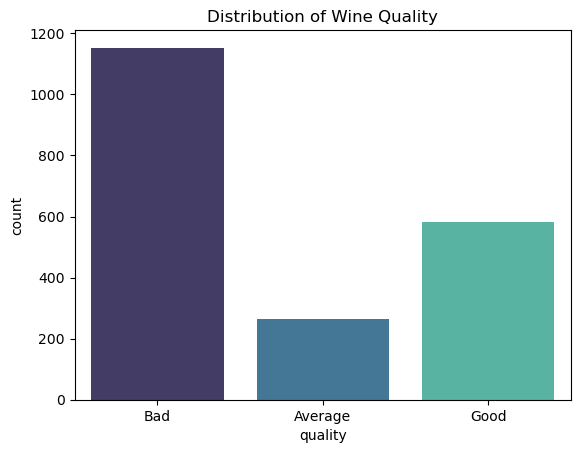

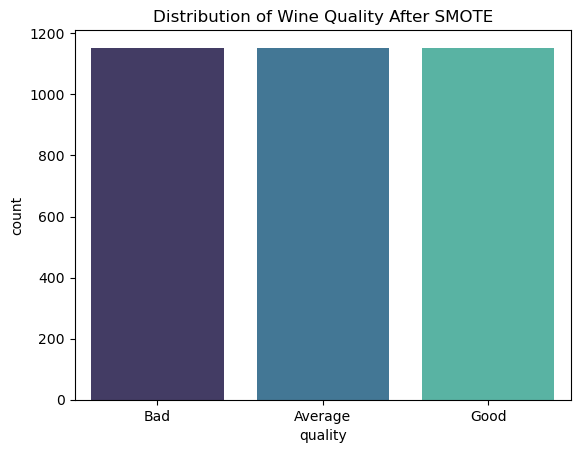

Loaded pre-trained models.
Selected Features: Index(['acid', 'sul', 'phenolics', 'acetic_acid', 'butanoic_acid'], dtype='object')
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Combining predictions using weighted probabilities...
Random Forest Weight: 0.5
Gradient Boosting Weight: 0.5

Combined Model Accuracy on test data: 99.71%

Combined Model Confusion Matrix:


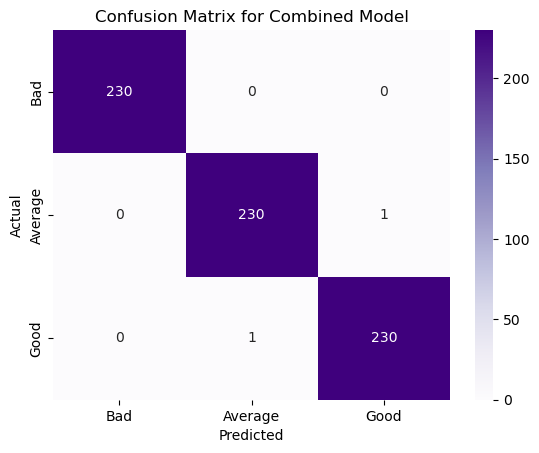


Combined Model Classification Report:
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00       230
         Bad       1.00      1.00      1.00       231
        Good       1.00      1.00      1.00       231

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692

Models saved to 'best_rf_model.pkl' and 'best_gb_model.pkl'

--- Enter details for a single wine sample ---


In [ ]:
# Import necessary libraries 169 lines of code and 256 including the comments and unecessary spacing 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib
from statistics import mode
import os  # For file handling
import warnings
warnings.filterwarnings("ignore")

# Load the dataset from the provided file name
data = pd.read_csv('wine quality data set 2000.csv')

# Check basic information about the dataset
print("Dataset Information:")
print(data.info())
print("\nFirst five rows of the dataset:")
print(data.head())

# Binarize the target into 3 categories: 5->'Bad', 6->'Average', 7+->'Good'
data['quality'] = data['quality'].apply(lambda x: 'Good' if x >= 7 else 'Average' if x == 6 else 'Bad')

# Visualize the dataset with custom colors
sns.countplot(x='quality', data=data, palette="mako")
plt.title('Distribution of Wine Quality')
plt.show()

# Split the data into features (X) and the target variable (y)
X = data.drop('quality', axis=1)
y = data['quality']

# Use SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Visualize the distribution after SMOTE
sns.countplot(x=y, palette="mako")
plt.title('Distribution of Wine Quality After SMOTE')
plt.show()

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check if we already have pre-trained models and load them
rf_model_path = 'best_rf_model.pkl'
gb_model_path = 'best_gb_model.pkl'
if os.path.exists(rf_model_path) and os.path.exists(gb_model_path):
    best_rf_model = joblib.load(rf_model_path)
    best_gb_model = joblib.load(gb_model_path)
    print("Loaded pre-trained models.")
else:
    # Initialize models
    best_rf_model = RandomForestClassifier(random_state=42)
    best_gb_model = GradientBoostingClassifier(random_state=42)

# Feature Selection using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
selector = RFE(rf, n_features_to_select=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the names of the selected features
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
}

# Use StratifiedKFold for better cross-validation
cv = StratifiedKFold(n_splits=5)

# Grid search for Random Forest
grid_search_rf = GridSearchCV(estimator=best_rf_model, param_grid=param_grid_rf, cv=cv, verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train_selected, y_train)
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")

# Grid search for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=best_gb_model, param_grid=param_grid_gb, cv=cv, verbose=2, n_jobs=-1)
grid_search_gb.fit(X_train_selected, y_train)
print(f"Best Gradient Boosting Parameters: {grid_search_gb.best_params_}")

# Train the models with the best parameters
best_rf_model = grid_search_rf.best_estimator_
best_gb_model = grid_search_gb.best_estimator_

# Combine predictions using weighted probabilities
# Assign weights to the models (you can tune these weights)
weight_rf = 0.5
weight_gb = 0.5

print("\nCombining predictions using weighted probabilities...")
print(f"Random Forest Weight: {weight_rf}")
print(f"Gradient Boosting Weight: {weight_gb}")

# Get probabilities for each model
prob_rf = best_rf_model.predict_proba(X_test_selected)
prob_gb = best_gb_model.predict_proba(X_test_selected)

# Calculate combined probabilities
prob_combined = (weight_rf * prob_rf) + (weight_gb * prob_gb)

# Get final predictions based on the highest combined probability
y_pred_combined = [best_rf_model.classes_[np.argmax(prob)] for prob in prob_combined]

# Output the accuracy of the combined model
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"\nCombined Model Accuracy on test data: {accuracy_combined * 100:.2f}%")

# Display the confusion matrix for the combined model
print("\nCombined Model Confusion Matrix:")
cm_combined = confusion_matrix(y_test, y_pred_combined)
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Purples', xticklabels=['Bad', 'Average', 'Good'], yticklabels=['Bad', 'Average', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Combined Model')
plt.show()

# Classification Report for the combined model
print("\nCombined Model Classification Report:")
report_combined = classification_report(y_test, y_pred_combined)
print(report_combined)

# Save the models
joblib.dump(best_rf_model, rf_model_path)
joblib.dump(best_gb_model, gb_model_path)
print("Models saved to 'best_rf_model.pkl' and 'best_gb_model.pkl'")

# Define valid input ranges for features
valid_ranges = {
     'ethanol': (8.0, 15.0),
    'pH': (2.5, 4.5),
    'acid': (0.1, 1.5),
    'sul': (1.0, 300.0),  # assuming 'sul' as a general sulfur dioxide-related feature
    'sugar': (0.5, 15.0),
    'phenolics': (0.1, 5.0),  # assuming general phenolics content range
    'anthocyanin': (0.0, 1.0),
    'ethyl_acetate': (0.01, 1.0),
    'ethyl_2_methylpropanoate': (0.01, 1.0),
    'ethyl_butanoate': (0.01, 1.0),
    # Adding remaining features in the dataset with reasonable assumed ranges
    'ethyl_3_methylbutanoate': (0.01, 1.0),
    'methylpropan_1_ol': (0.01, 1.0),
    'methylbutyl_acetate': (0.01, 1.0),
    'ethyl_pentanoate': (0.01, 1.0),
    'methylbutan_1_ol': (0.01, 1.0),
    'ethyl_hexanoate': (0.01, 1.0),
    'hexyl_acetate': (0.01, 1.0),
    'ethyl_2_hydroxypropanoate': (0.01, 1.0),
    'hexan_1_ol': (0.01, 1.0),
    'hex_3_en_1_ol': (0.01, 1.0),
    'heptan_1_ol': (0.01, 1.0),
    'ethyl_octanoate': (0.01, 1.0),
    'benzaldehyde': (0.01, 0.1),
    'ethyl_decanoate': (0.01, 1.0),
    'phenol': (0.01, 0.1),
    '2_methoxyphenol': (0.01, 0.1),
    'ethyl_3_phenylpropanoate': (0.01, 1.0),
    'acetic_acid': (0.01, 1.0),
    'butanoic_acid': (0.01, 1.0),
    'octanoic_acid': (0.01, 1.0),
    'hexanoic_acid': (0.01, 1.0),
}

# Now, allow the user to input new values for prediction
print("\n--- Enter details for a single wine sample ---")

# Define a function to get valid input from the user
def get_float_input(prompt, feature):
    while True:
        try:
            value = float(input(prompt))
            if valid_ranges[feature][0] <= value <= valid_ranges[feature][1]:
                return value
            else:
                print(f"Invalid input. Please enter a value between {valid_ranges[feature][0]} and {valid_ranges[feature][1]}.")
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

# Dictionary to hold user inputs
user_input = {}

# Prompt the user for the selected features only
for feature in selected_features:
    user_input[feature] = get_float_input(f"Enter {feature}: ", feature)

# Create a DataFrame for the input values with all features
full_input = pd.DataFrame(columns=X.columns, index=[0])

# Fill in the values for the selected features
for feature in selected_features:
    full_input.loc[0, feature] = user_input[feature]

# Fill in the remaining features with zero
for feature in X.columns:
    if feature not in selected_features:
        full_input.loc[0, feature] = 0

# Ensure the input has the right shape for scaling
single_input_scaled = scaler.transform(full_input)

# Use the selector to transform the scaled input
single_input_selected = selector.transform(single_input_scaled)

# Make predictions and get probabilities using the best models
single_prob_rf = best_rf_model.predict_proba(single_input_selected)[0]
single_prob_gb = best_gb_model.predict_proba(single_input_selected)[0]

# Combine probabilities using the assigned weights
single_prob_combined = (weight_rf * single_prob_rf) + (weight_gb * single_prob_gb)

# Determine the final prediction based on the highest combined probability
single_prediction_combined = best_rf_model.classes_[np.argmax(single_prob_combined)]

# Print probabilities for each class as percentages in an organized format
print("\nPrediction Probabilities (as percentages):")
print(f"{'Quality':<10} {'Random Forest':>15} {'Gradient Boosting':>20} {'Combined':>15}")
print("=" * 60)

for label, p_rf, p_gb, p_comb in zip(best_rf_model.classes_, single_prob_rf, single_prob_gb, single_prob_combined):
    print(f"{label:<10} {p_rf * 100:>15.2f}% {p_gb * 100:>20.2f}% {p_comb * 100:>15.2f}%")

# Output the predicted wine quality
print(f"\nPredicted Wine Quality (Combined): {single_prediction_combined}")

# Provide feedback based on the quality score
if single_prediction_combined == 'Good':
    print("This wine is of good quality! A great choice!")
elif single_prediction_combined == 'Average':
    print("This wine is of average quality. It might be worth trying!")
else:
    print("This wine is of below-average quality. You might want to reconsider!")